    Jacob Knopping
    2/25/2020
    
    26.3 Assignment

### Part I: Iris dataset

__1) Get the silhouette coefficient of the two cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above where cluster number is three. We know that the Iris dataset consists of three different clusters. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?__

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics

In [2]:
# THREE CLUSTERS

#Load Iris dataset
iris_df = datasets.load_iris()
X = iris_df.data
y = iris_df.target

#Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#Fit and predict
pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

In [3]:
#Three cluster k-means silhouette coefficient

sc_3 = metrics.silhouette_score(X_std, pred, metric='euclidean')
print(sc_3)

0.45994823920518635


In [4]:
# TWO CLUSTERS

#Load Iris dataset
iris_df = datasets.load_iris()
X = iris_df.data
y = iris_df.target

#Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#Fit and predict
pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

In [5]:
#Two cluster k-means silhouette coefficient

sc_3 = metrics.silhouette_score(X_std, pred, metric='euclidean')
print(sc_3)

0.5817500491982808


In this case the silhouette score is higher for k=2 than k=3. This is because one cluster is linearly seperable from the other two, which are more similar. Thus the total of two clusters will result in a higher silhouette score because the silhouette score is a measure of similarity-combining the two similar clusters into one makes similarity greater, even though k=3 is a more accurate solution with the correct number of clusters of 3. 

### Part II: Heart Disease Dataset

__1) Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?__

In [6]:
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [7]:
# Make sure the number of rows divides evenly into four samples.
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Define the features and the outcome
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [8]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [9]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

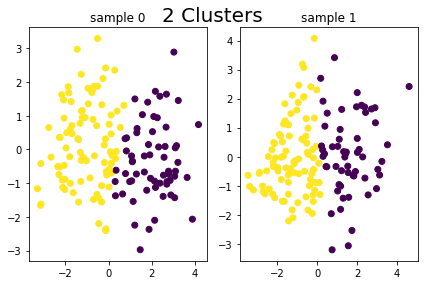

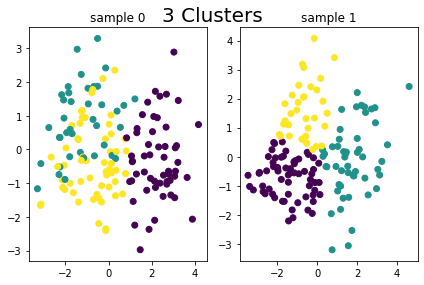

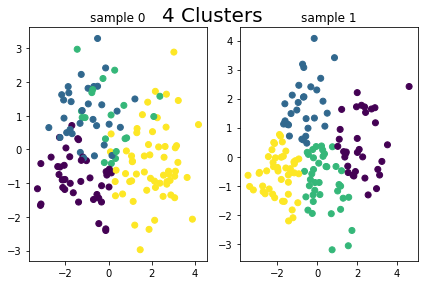

In [10]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

2 clusters is the correct solution, as this is the only solution where each cluster has consistent, visual seperation from one another across both samples. 

__2) Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?__

In [11]:
# ARI Scores

k2_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
k3_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
k4_pred = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI score for 2 clusters: {}".format(metrics.adjusted_rand_score(y, k2_pred)))
print("ARI score for 3 clusters: {}".format(metrics.adjusted_rand_score(y, k3_pred)))
print("ARI score for 4 clusters: {}".format(metrics.adjusted_rand_score(y, k4_pred)))

ARI score for 2 clusters: 0.43661540614807665
ARI score for 3 clusters: 0.280694132678885
ARI score for 4 clusters: 0.1968993286830863


Based on ARI scores, two clusters is the best solution (highest ARI score).

__3) Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?__

In [12]:
# Silhouette coefficients

k2_sc = metrics.silhouette_score(X_std, k2_pred, metric='euclidean')
k3_sc = metrics.silhouette_score(X_std, k3_pred, metric='euclidean')
k4_sc = metrics.silhouette_score(X_std, k4_pred, metric='euclidean')

print("Silhouette coefficient for 2 clusters: {}".format(k2_sc))
print("Silhouette coefficient for 3 clusters: {}".format(k3_sc))
print("Silhouette coefficient for 4 clusters: {}".format(k4_sc))

Silhouette coefficient for 2 clusters: 0.17440650461256255
Silhouette coefficient for 3 clusters: 0.12862190702187828
Silhouette coefficient for 4 clusters: 0.13186062012858554


The silhouette coefficient for 2 clusters yields the greatest value; similarity among data points in each cluster is greatest for 2 clusters. Therefore, 2 clusters is again the best solution. 